# Goal

* Analyze results from `atomIncorp_taxaIncorp` simulation

# Var

In [6]:
workDir = '/ebio/abt3_projects/methanogen_host_evo/SIPSim_pt2/data/bac_genome1147/atomIncorp_taxaIncorp/'

# Init

In [7]:
library(dplyr)
library(tidyr)
library(ggplot2)

In [8]:
# classifying true positives, neg, ...
clsfy = function(guess,known){
    if(is.na(guess) | is.na(known)){
        return(NA)
        }
    if(guess == TRUE){
        if(guess == known){
            return('True positive')
            } else {
            return('False positive')
            }
        } else
    if(guess == FALSE){
        if(guess == known){
            return('True negative')
            } else {
            return('False negative')
            }
        } else {
        stop('Error: true or false needed')
        }
    }

# Load

In [18]:
# files on simulation accuracy
files = list.files(path=workDir, pattern='*-cMtx_byClass.txt', full.names=TRUE)
files

[1] "/ebio/abt3_projects/methanogen_host_evo/SIPSim_pt2/data/bac_genome1147/atomIncorp_taxaIncorp//DESeq2_multi-cMtx_byClass.txt"
[2] "/ebio/abt3_projects/methanogen_host_evo/SIPSim_pt2/data/bac_genome1147/atomIncorp_taxaIncorp//DESeq2-cMtx_byClass.txt"      
[3] "/ebio/abt3_projects/methanogen_host_evo/SIPSim_pt2/data/bac_genome1147/atomIncorp_taxaIncorp//heavy-cMtx_byClass.txt"       
[4] "/ebio/abt3_projects/methanogen_host_evo/SIPSim_pt2/data/bac_genome1147/atomIncorp_taxaIncorp//heavyM1-cMtx_byClass.txt"     
[5] "/ebio/abt3_projects/methanogen_host_evo/SIPSim_pt2/data/bac_genome1147/atomIncorp_taxaIncorp//heavyM2-cMtx_byClass.txt"     
[6] "/ebio/abt3_projects/methanogen_host_evo/SIPSim_pt2/data/bac_genome1147/atomIncorp_taxaIncorp//heavyM3-cMtx_byClass.txt"     
[7] "/ebio/abt3_projects/methanogen_host_evo/SIPSim_pt2/data/bac_genome1147/atomIncorp_taxaIncorp//heavyM4-cMtx_byClass.txt"     
[8] "/ebio/abt3_projects/methanogen_host_evo/SIPSim_pt2/data/bac_genome1147/atomIncorp_taxaIncorp//qSIP-cMtx_byClass.txt"

In [19]:
# combining files
df_byClass = list()
for (f in files){
    ff = strsplit(f, '/') %>% unlist
    fff = ff[length(ff)]
    df_byClass[[fff]] = read.delim(f, sep='\t')
}

df_byClass = do.call(rbind, df_byClass)
df_byClass$file = gsub('\\.[0-9]+$', '', rownames(df_byClass))
df_byClass$method = gsub('-.+', '', df_byClass$file)
rownames(df_byClass) = 1:nrow(df_byClass)

df_byClass %>% dim %>% print
df_byClass %>% head(n=3)

[1] 57600     8


,library,variables,values,percIncorp,percTaxa,rep,file,method
1,2,Sensitivity,NA,0,1,1,DESeq2_multi-cMtx_byClass.txt,DESeq2_multi
2,2,Specificity,1,0,1,1,DESeq2_multi-cMtx_byClass.txt,DESeq2_multi
3,2,Pos Pred Value,NA,0,1,1,DESeq2_multi-cMtx_byClass.txt,DESeq2_multi


In [20]:
df_byClass$method %>% table

.
      DESeq2 DESeq2_multi        heavy      heavyM1      heavyM2      heavyM3 
        7200         7200         7200         7200         7200         7200 
     heavyM4         qSIP 
        7200         7200 

In [21]:
# renaming methods
rename = data.frame(method = c('DESeq2', 'DESeq2_multi', 'heavyM1', 'qSIP'), 
                   method_new = c('HR-SIP', 'MW-HR-SIP', 'Heavy-SIP', 'q-SIP'))

df_byClass = inner_join(df_byClass, rename, c('method'='method')) %>%
    select(-method) %>%
    rename('method' = method_new) 

df_byClass %>% dim %>% print
df_byClass %>% head(n=3)

Warning message in inner_join_impl(x, y, by$x, by$y, suffix$x, suffix$y):
“joining character vector and factor, coercing into character vector”

[1] 28800     8


,library,variables,values,percIncorp,percTaxa,rep,file,method
1,2,Sensitivity,NA,0,1,1,DESeq2_multi-cMtx_byClass.txt,MW-HR-SIP
2,2,Specificity,1,0,1,1,DESeq2_multi-cMtx_byClass.txt,MW-HR-SIP
3,2,Pos Pred Value,NA,0,1,1,DESeq2_multi-cMtx_byClass.txt,MW-HR-SIP


# Incorp-call accuracy

Warning message:
“Removed 81 rows containing missing values (geom_pointrange).”

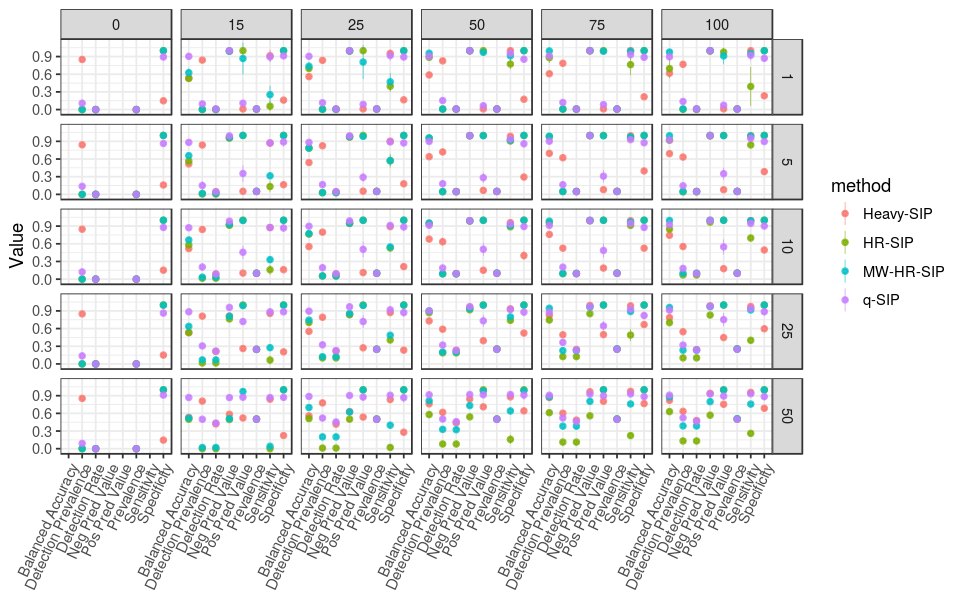

In [22]:
# summarize by SIPSim rep & library rep
df_byClass.s = df_byClass %>%
    group_by(method, percIncorp, percTaxa, variables) %>%
    summarize(mean_value = mean(values, na.rm=TRUE),
              sd_value = sd(values, na.rm=TRUE))

# plotting
options(repr.plot.width=8, repr.plot.height=5)
p = ggplot(df_byClass.s, aes(variables, mean_value, color=method,
                         ymin=mean_value-sd_value,
                         ymax=mean_value+sd_value)) +
    geom_pointrange(alpha=0.8, size=0.2) +
    labs(y='Value') +
    facet_grid(percTaxa ~ percIncorp) +
    theme_bw() +
    theme(
        axis.title.x = element_blank(),
        axis.text.x = element_text(angle=65, hjust=1)
    )
plot(p)

Warning message:
“Removed 40 rows containing missing values (geom_point).”Warning message:
“Removed 40 rows containing missing values (geom_linerange).”Warning message:
“Removed 5 rows containing missing values (geom_path).”

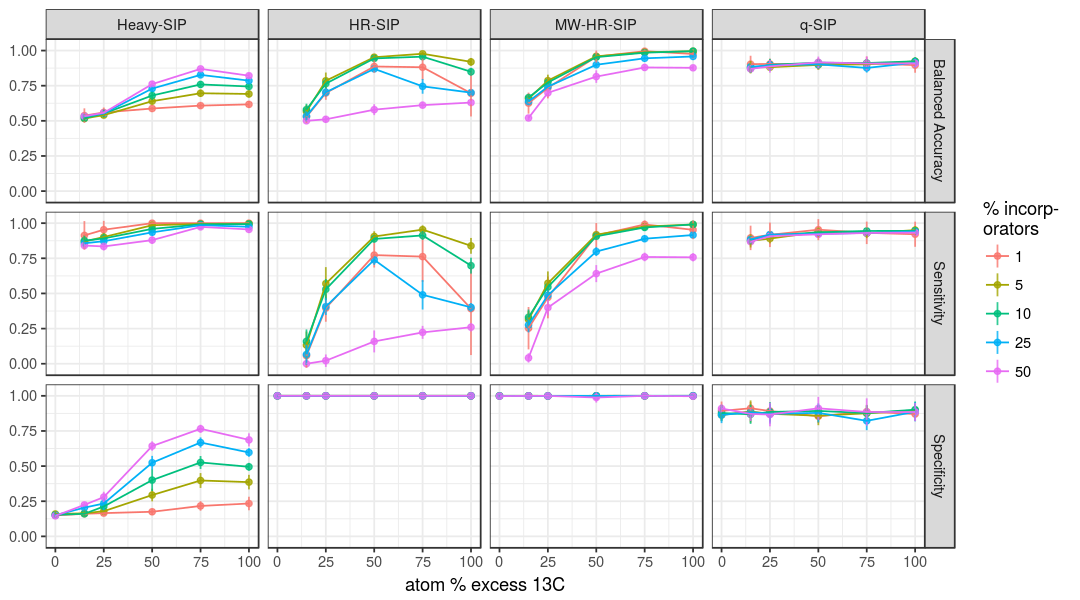

In [23]:
# summarize by SIPSim rep & library rep
vars = c('Balanced Accuracy', 'Sensitivity', 'Specificity')
df_byClass.s.f = df_byClass.s %>%
    filter(variables %in% vars) %>%
    ungroup() %>%
    mutate(percTaxa = percTaxa %>% as.character,
           percTaxa = percTaxa %>% reorder(percTaxa %>% as.numeric))


# plotting
options(repr.plot.width=9, repr.plot.height=5)
p.pnt = ggplot(df_byClass.s.f, aes(percIncorp, mean_value, 
                           color=percTaxa, 
                           group=percTaxa,
                           ymin=mean_value-sd_value,
                           ymax=mean_value+sd_value)) +
    geom_point(alpha=0.8) +
    geom_linerange(alpha=0.8, size=0.5) +
    geom_line() +
    scale_color_discrete('% incorp-\norators') +
    labs(x='atom % excess 13C') +
    facet_grid(variables ~ method) +
    theme_bw() +
    theme(
        axis.title.y = element_blank()
    )
plot(p.pnt)

In [24]:
outF = file.path(workDir, 'atomIncorp_taxaIncorp_acc.pdf')
ggsave(outF, p.pnt, width=10, height=6)
cat('File written:', outF, '\n')

Warning message:
“Removed 40 rows containing missing values (geom_point).”Warning message:
“Removed 40 rows containing missing values (geom_linerange).”Warning message:
“Removed 5 rows containing missing values (geom_path).”

File written: /ebio/abt3_projects/methanogen_host_evo/SIPSim_pt2/data/bac_genome1147/atomIncorp_taxaIncorp//atomIncorp_taxaIncorp_acc.pdf 


In [25]:
outF = file.path(workDir, 'atomIncorp_taxaIncorp_acc.jpeg')
ggsave(outF, p.pnt, width=10, height=6)
cat('File written:', outF, '\n')

Warning message:
“Removed 40 rows containing missing values (geom_point).”Warning message:
“Removed 40 rows containing missing values (geom_linerange).”Warning message:
“Removed 5 rows containing missing values (geom_path).”

File written: /ebio/abt3_projects/methanogen_host_evo/SIPSim_pt2/data/bac_genome1147/atomIncorp_taxaIncorp//atomIncorp_taxaIncorp_acc.jpeg 


## heavy-SIP methods accuracy

* comparing the various methods of heavy-SIP

In [35]:
# combining files
df_byClass = list()
for (f in files){
    ff = strsplit(f, '/') %>% unlist
    fff = ff[length(ff)]
    df_byClass[[fff]] = read.delim(f, sep='\t')
}

df_byClass = do.call(rbind, df_byClass)
df_byClass$file = gsub('\\.[0-9]+$', '', rownames(df_byClass))
df_byClass$method = gsub('-.+', '', df_byClass$file)
rownames(df_byClass) = 1:nrow(df_byClass)

df_byClass %>% dim %>% print
df_byClass %>% head(n=3)

[1] 57600     8


,library,variables,values,percIncorp,percTaxa,rep,file,method
1,2,Sensitivity,NA,0,1,1,DESeq2_multi-cMtx_byClass.txt,DESeq2_multi
2,2,Specificity,1,0,1,1,DESeq2_multi-cMtx_byClass.txt,DESeq2_multi
3,2,Pos Pred Value,NA,0,1,1,DESeq2_multi-cMtx_byClass.txt,DESeq2_multi


In [36]:
# renaming methods
rename = data.frame(method = c('heavyM1', 'heavyM2', 'heavyM3', 'heavyM4'), 
                   method_new = c('Heavy-SIP Method 1', 'Heavy-SIP Method 2', 
                                  'Heavy-SIP Method 3', 'Heavy-SIP Method 4'))

df_byClass = inner_join(df_byClass, rename, c('method'='method')) %>%
    select(-method) %>%
    rename('method' = method_new) 

df_byClass %>% dim %>% print
df_byClass %>% head(n=3)

Warning message in inner_join_impl(x, y, by$x, by$y, suffix$x, suffix$y):
“joining character vector and factor, coercing into character vector”

[1] 28800     8


,library,variables,values,percIncorp,percTaxa,rep,file,method
1,2,Sensitivity,NA,0,1,1,heavyM1-cMtx_byClass.txt,Heavy-SIP Method 1
2,2,Specificity,0.144283121597096,0,1,1,heavyM1-cMtx_byClass.txt,Heavy-SIP Method 1
3,2,Pos Pred Value,NA,0,1,1,heavyM1-cMtx_byClass.txt,Heavy-SIP Method 1


Warning message:
“Removed 40 rows containing missing values (geom_point).”Warning message:
“Removed 40 rows containing missing values (geom_linerange).”Warning message:
“Removed 5 rows containing missing values (geom_path).”

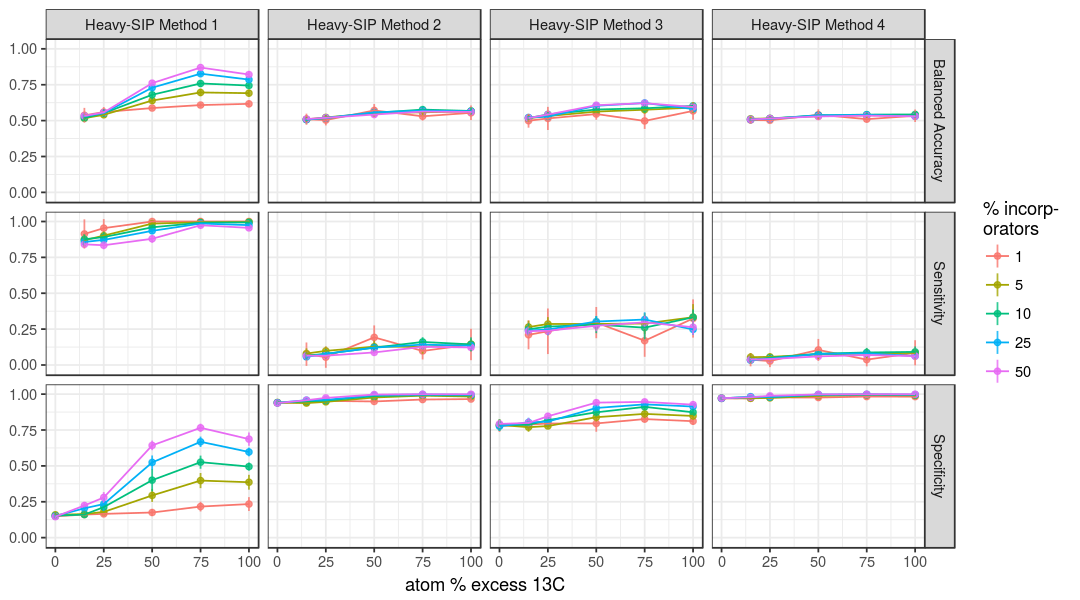

In [37]:
# summarizing by method
df_byClass.s = df_byClass %>%
    group_by(method, percIncorp, percTaxa, variables) %>%
    summarize(mean_value = mean(values, na.rm=TRUE),
              sd_value = sd(values, na.rm=TRUE)) %>%
    ungroup()

# summarize by SIPSim rep & library rep
vars = c('Balanced Accuracy', 'Sensitivity', 'Specificity')
df_byClass.s.f = df_byClass.s %>%
    filter(variables %in% vars) %>%
    ungroup() %>%
    mutate(percTaxa = percTaxa %>% as.character,
           percTaxa = percTaxa %>% reorder(percTaxa %>% as.numeric))


# plotting
options(repr.plot.width=9, repr.plot.height=5)
p.pnt.H = ggplot(df_byClass.s.f, aes(percIncorp, mean_value, 
                           color=percTaxa, 
                           group=percTaxa,
                           ymin=mean_value-sd_value,
                           ymax=mean_value+sd_value)) +
    geom_point(alpha=0.8) +
    geom_linerange(alpha=0.8, size=0.5) +
    geom_line() +
    scale_color_discrete('% incorp-\norators') +
    labs(x='atom % excess 13C') +
    facet_grid(variables ~ method) +
    theme_bw() +
    theme(
        axis.title.y = element_blank()
    )
plot(p.pnt.H)

In [38]:
outF = file.path(workDir, 'atomIncorp_taxaIncorp_acc-heavy.pdf')
ggsave(outF, p.pnt.H, width=10, height=6)
cat('File written:', outF, '\n')

Warning message:
“Removed 40 rows containing missing values (geom_point).”Warning message:
“Removed 40 rows containing missing values (geom_linerange).”Warning message:
“Removed 5 rows containing missing values (geom_path).”

File written: /ebio/abt3_projects/methanogen_host_evo/SIPSim_pt2/data/bac_genome1147/atomIncorp_taxaIncorp//atomIncorp_taxaIncorp_acc-heavy.pdf 


In [39]:
outF = file.path(workDir, 'atomIncorp_taxaIncorp_acc-heavy.jpeg')
ggsave(outF, p.pnt.H, width=10, height=6)
cat('File written:', outF, '\n')

Warning message:
“Removed 40 rows containing missing values (geom_point).”Warning message:
“Removed 40 rows containing missing values (geom_linerange).”Warning message:
“Removed 5 rows containing missing values (geom_path).”

File written: /ebio/abt3_projects/methanogen_host_evo/SIPSim_pt2/data/bac_genome1147/atomIncorp_taxaIncorp//atomIncorp_taxaIncorp_acc-heavy.jpeg 


# Sensitivity ~ abundance

* `sensitivity = true_positive / (true_positive + false_negative)`
* `sensitivity = true_incorporators_called_incorporators / (true_incorporators)`

## Load true BD shift

In [40]:
BDshift_files = list.files(path=workDir, pattern='BD-shift_stats.txt', full.names=TRUE, recursive=TRUE)
BDshift_files %>% length %>% print

[1] 300


In [41]:
df_shift = list()
for(F in BDshift_files){
    tmp = read.delim(F, sep='\t') 
    FF = strsplit(F, '/') %>% unlist
    FFl = length(FF)
    tmp$percIncorp = FF[FFl-3]
    tmp$percTaxa = FF[FFl-2]
    tmp$rep = FF[FFl-1]
    tmp$file = FF[FFl]
    df_shift[[F]] = tmp
}

df_shift = do.call(rbind, df_shift)
rownames(df_shift) = 1:nrow(df_shift)

df_shift = df_shift %>%
    filter(library %in% c(2,4,6)) %>%
    group_by(taxon, percIncorp, percTaxa, rep) %>%
    summarize(median = median(median)) %>%
    ungroup() %>%
    rename('median_true_BD_shift' = median) %>%
    mutate(true_incorporator = ifelse(median_true_BD_shift > 0.002, TRUE, FALSE))

# status
df_shift %>% nrow %>% print
df_shift %>% head(n=3)

[1] 330600


,taxon,percIncorp,percTaxa,rep,median_true_BD_shift,true_incorporator
1,Acaryochloris_marina_MBIC11017,0,1,1,0,FALSE
2,Acaryochloris_marina_MBIC11017,0,1,10,0,FALSE
3,Acaryochloris_marina_MBIC11017,0,1,2,0,FALSE


## Loading original taxon abundances

In [42]:
comm_files = list.files(path=workDir, pattern='comm.txt', full.names=TRUE, recursive=TRUE)
comm_files %>% length %>% print

[1] 300


In [43]:
df_comm = list()
for(F in comm_files){
    tmp = read.delim(F, sep='\t') 
    FF = strsplit(F, '/') %>% unlist
    FFl = length(FF)
    tmp$percIncorp = FF[FFl-3]
    tmp$percTaxa = FF[FFl-2]
    tmp$rep = FF[FFl-1]
    tmp$file = FF[FFl]
    df_comm[[F]] = tmp
}

df_comm = do.call(rbind, df_comm)
rownames(df_comm) = 1:nrow(df_comm)


# mean abund for libraries
df_comm = df_comm %>%
    rename('taxon' = taxon_name) %>%
    group_by(taxon, percIncorp, percTaxa, rep) %>%
    summarize(mean_rel_abund_perc = mean(rel_abund_perc),
              mean_rank_abund = mean(rank)) %>%
    ungroup()

# status
df_comm %>% nrow %>% print
df_comm %>% head(n=3)

[1] 344100


,taxon,percIncorp,percTaxa,rep,mean_rel_abund_perc,mean_rank_abund
1,Acaryochloris_marina_MBIC11017,0,1,1,0.000160130833333333,1132
2,Acaryochloris_marina_MBIC11017,0,1,10,0.00469008133333333,798
3,Acaryochloris_marina_MBIC11017,0,1,2,0.00977526783333333,647


## Load MW-HR-SIP incorp tables

In [44]:
MW_files = list.files(path=workDir, pattern='_MW_DESeq2_incorp.txt', full.names=TRUE, recursive=TRUE)
MW_files %>% length %>% print

[1] 300


In [45]:
df_MW = list()
#for(F in MW_files){
for(F in MW_files){
    tmp = read.delim(F, sep='\t') 
    FF = strsplit(F, '/') %>% unlist
    FFl = length(FF)
    tmp$percIncorp = FF[FFl-3]
    tmp$percTaxa = FF[FFl-2]
    tmp$rep = FF[FFl-1]
    tmp$file = FF[FFl]
    df_MW[[F]] = tmp
}

df_MW = do.call(rbind, df_MW)
rownames(df_MW) = 1:nrow(df_MW)

# status
df_MW %>% nrow %>% print
df_MW %>% head(n=3)

[1] 325714


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,p,occur_all,occur_heavy,heavy_BD_min,heavy_BD_max,taxon,incorp,percIncorp,percTaxa,rep,file
1,0.884105945035489,0.111588469029128,0.244664820177346,0.456087102952698,0.64832734400823,0.999101550982867,0.714207582519989,0,0,1.7,1.73,Acetobacterium_woodii_DSM_1030,FALSE,0,1,1,OTU_abs1e9_PCR_sub_filt_MW_DESeq2_incorp.txt
2,0.0165548198802344,0.00234709120439762,0.0927951086456159,0.0252932642534118,0.979821046561109,0.999101550982867,0.99619402335997,0,0,1.7,1.73,Acetohalobium_arabaticum_DSM_5501,FALSE,0,1,1,OTU_abs1e9_PCR_sub_filt_MW_DESeq2_incorp.txt
3,74.3247643944758,-0.0622072497160417,0.265688586529032,-0.234135950394859,0.814879437102672,0.999101550982867,0.880020078820434,0,0,1.7,1.73,Acholeplasma_laidlawii_PG-8A,FALSE,0,1,1,OTU_abs1e9_PCR_sub_filt_MW_DESeq2_incorp.txt


## group by abundance and calculate sensitivity

In [46]:
join_vars = c('taxon' = 'taxon',
              'percIncorp'='percIncorp',
              'percTaxa'='percTaxa',
              'rep'='rep')

# joining tables
df_MW %>% nrow %>% print
df.j = df_MW %>% 
    left_join(df_shift, join_vars)

df.j %>% nrow %>% print
df.j = df.j %>% 
    left_join(df_comm, join_vars)

# status
df.j %>% nrow %>% print
df.j %>% head(n=3)

[1] 325714


Warning message in left_join_impl(x, y, by$x, by$y, suffix$x, suffix$y):
“joining factors with different levels, coercing to character vector”

[1] 325714


Warning message in left_join_impl(x, y, by$x, by$y, suffix$x, suffix$y):
“joining factor and character vector, coercing into character vector”

[1] 325714


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,p,occur_all,occur_heavy,heavy_BD_min,⋯,taxon,incorp,percIncorp,percTaxa,rep,file,median_true_BD_shift,true_incorporator,mean_rel_abund_perc,mean_rank_abund
1,0.884105945035489,0.111588469029128,0.244664820177346,0.456087102952698,0.64832734400823,0.999101550982867,0.714207582519989,0,0,1.7,⋯,Acetobacterium_woodii_DSM_1030,FALSE,0,1,1,OTU_abs1e9_PCR_sub_filt_MW_DESeq2_incorp.txt,0,FALSE,0.010590597,612
2,0.0165548198802344,0.00234709120439762,0.0927951086456159,0.0252932642534118,0.979821046561109,0.999101550982867,0.99619402335997,0,0,1.7,⋯,Acetohalobium_arabaticum_DSM_5501,FALSE,0,1,1,OTU_abs1e9_PCR_sub_filt_MW_DESeq2_incorp.txt,0,FALSE,0.000280318833333333,1116
3,74.3247643944758,-0.0622072497160417,0.265688586529032,-0.234135950394859,0.814879437102672,0.999101550982867,0.880020078820434,0,0,1.7,⋯,Acholeplasma_laidlawii_PG-8A,FALSE,0,1,1,OTU_abs1e9_PCR_sub_filt_MW_DESeq2_incorp.txt,0,FALSE,2.8297827285,4


In [47]:
# calling true_pos + false_neg
df.j = df.j %>%
    mutate(incorp_cls = mapply(clsfy, incorp, true_incorporator)) 

# status
df.j %>% nrow %>% print
df.j$incorp_cls %>% table %>% print

[1] 325714
.
False negative False positive  True negative  True positive 
         19542            221         276293          29658 


In [48]:
# function for calculating sensitivity
calc_sensitivity = function(incorp_cls){
    tp = sum(incorp_cls == 'True positive')
    fn = sum(incorp_cls == 'False negative')
    x = tp / (tp + fn)
    ifelse(is.na(x), 0, x)
}

# grouping by abundance and calculating sensitivity
df.j.s = df.j %>%
    mutate(n_group = ntile(log10(mean_rel_abund_perc), 10)) %>%
    group_by(n_group, percIncorp, percTaxa, rep) %>%
    summarize(min_abund = min(mean_rel_abund_perc, na.rm=TRUE),
              mean_abund = mean(mean_rel_abund_perc, na.rm=TRUE),
              max_abund = max(mean_rel_abund_perc, na.rm=TRUE),
              sensitivity = calc_sensitivity(incorp_cls)) %>%
    group_by(n_group, percIncorp, percTaxa) %>%
    summarize(mean_abund = mean(mean_abund),
              mean_sensitivity = mean(sensitivity),
              sd_sensitivity = sd(sensitivity)) %>%
    ungroup() %>%
    mutate(percIncorp = percIncorp %>% as.character,
           percIncorp = percIncorp %>% reorder(percIncorp %>% as.numeric),
           percTaxa = percTaxa %>% as.character,
           percTaxa = percTaxa %>% reorder(percTaxa %>% as.numeric))

# status
df.j.s %>% head(n=3)

,n_group,percIncorp,percTaxa,mean_abund,mean_sensitivity,sd_sensitivity
1,1,0,1,0.000541435583722446,0,0
2,1,0,10,0.000538607903349629,0,0
3,1,0,25,0.000539384534144416,0,0


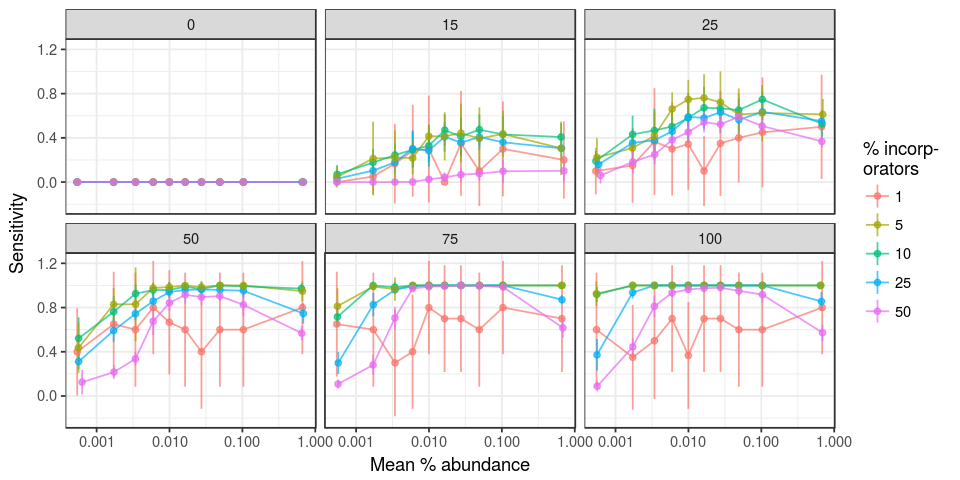

In [49]:
# plotting
options(repr.plot.width=8, repr.plot.height=4)
p_sens_abund = ggplot(df.j.s, aes(mean_abund, mean_sensitivity, 
                                  color=percTaxa,
                                  ymin=mean_sensitivity-sd_sensitivity,
                                  ymax=mean_sensitivity+sd_sensitivity)) +
    geom_line(alpha=0.7) +
    geom_linerange(alpha=0.7) +
    geom_point(alpha=0.7) +
    scale_x_log10(breaks=c(1e-3, 1e-2, 1e-1, 1e0)) +
    scale_color_discrete('% incorp-\norators') +
    labs(x='Mean % abundance',
         y='Sensitivity') +
    facet_wrap(~ percIncorp) +
    theme_bw()

p_sens_abund

In [50]:
outF = file.path(workDir, 'atomIncorp_taxaIncorp_sens-abund.pdf')
ggsave(outF, p_sens_abund, width=10, height=5)
cat('File written:', outF, '\n')

File written: /ebio/abt3_projects/methanogen_host_evo/SIPSim_pt2/data/bac_genome1147/atomIncorp_taxaIncorp//atomIncorp_taxaIncorp_sens-abund.pdf 


In [51]:
outF = file.path(workDir, 'atomIncorp_taxaIncorp_sens-abund.jpeg')
ggsave(outF, p_sens_abund, width=10, height=5)
cat('File written:', outF, '\n')

File written: /ebio/abt3_projects/methanogen_host_evo/SIPSim_pt2/data/bac_genome1147/atomIncorp_taxaIncorp//atomIncorp_taxaIncorp_sens-abund.jpeg 


# BD shift quantify

## True BD shift

In [52]:
BDshift_files = list.files(path=workDir, pattern='BD-shift_stats.txt', full.names=TRUE, recursive=TRUE)
BDshift_files %>% length %>% print

[1] 300


In [53]:
df_shift = list()
for(F in BDshift_files){
    tmp = read.delim(F, sep='\t') 
    FF = strsplit(F, '/') %>% unlist
    FFl = length(FF)
    tmp$percIncorp = FF[FFl-3]
    tmp$percTaxa = FF[FFl-2]
    tmp$rep = FF[FFl-1]
    tmp$file = FF[FFl]
    df_shift[[F]] = tmp
}

df_shift = do.call(rbind, df_shift)
rownames(df_shift) = 1:nrow(df_shift)

df_shift = df_shift %>%
    filter(library %in% c(2,4,6)) %>%
    group_by(taxon, percIncorp, percTaxa, rep) %>%
    summarize(median = median(median)) %>%
    ungroup() %>%
    rename('median_true_BD_shift' = median) 

# status
df_shift %>% nrow %>% print
df_shift %>% head(n=3)

[1] 330600


,taxon,percIncorp,percTaxa,rep,median_true_BD_shift
1,Acaryochloris_marina_MBIC11017,0,1,1,0
2,Acaryochloris_marina_MBIC11017,0,1,10,0
3,Acaryochloris_marina_MBIC11017,0,1,2,0


## MW-HR-SIP incorp calls

* filtering BD shift estimates to just incorporators identified by MW-HR-SIP

In [54]:
incorp_files = list.files(path=workDir, pattern='OTU_abs1e9_PCR_sub_filt_MW_DESeq2_incorp.txt', full.names=TRUE, recursive=TRUE)
incorp_files %>% length %>% print

[1] 300


In [55]:
df_incorp = list()
for(F in incorp_files){
    tmp = read.delim(F, sep='\t') 
    FF = strsplit(F, '/') %>% unlist
    FFl = length(FF)
    tmp$percIncorp = FF[FFl-3]
    tmp$percTaxa = FF[FFl-2]
    tmp$rep = FF[FFl-1]
    tmp$file = FF[FFl]
    df_incorp[[F]] = tmp
}

df_incorp = do.call(rbind, df_incorp)
rownames(df_incorp) = 1:nrow(df_incorp)
df_incorp %>% head(n=3) %>% print

     baseMean log2FoldChange      lfcSE        stat    pvalue      padj
1  0.88410595    0.111588469 0.24466482  0.45608710 0.6483273 0.9991016
2  0.01655482    0.002347091 0.09279511  0.02529326 0.9798210 0.9991016
3 74.32476439   -0.062207250 0.26568859 -0.23413595 0.8148794 0.9991016
          p occur_all occur_heavy heavy_BD_min heavy_BD_max
1 0.7142076         0           0          1.7         1.73
2 0.9961940         0           0          1.7         1.73
3 0.8800201         0           0          1.7         1.73
                              taxon incorp percIncorp percTaxa rep
1    Acetobacterium_woodii_DSM_1030  FALSE          0        1   1
2 Acetohalobium_arabaticum_DSM_5501  FALSE          0        1   1
3      Acholeplasma_laidlawii_PG-8A  FALSE          0        1   1
                                          file
1 OTU_abs1e9_PCR_sub_filt_MW_DESeq2_incorp.txt
2 OTU_abs1e9_PCR_sub_filt_MW_DESeq2_incorp.txt
3 OTU_abs1e9_PCR_sub_filt_MW_DESeq2_incorp.txt


In [56]:
# just incorporators
df_incorp = df_incorp %>%
    filter(incorp == TRUE) %>%
    dplyr::distinct(taxon, incorp, percIncorp, percTaxa, rep) %>%
    rename('HWHRSIP_incorp' = incorp)

df_incorp %>% nrow %>% print
df_incorp %>% head(n=3) %>% print

[1] 29879
                               taxon HWHRSIP_incorp percIncorp percTaxa rep
1 Bifidobacterium_pseudolongum_PV8-2           TRUE          0        1   6
2     Alkaliphilus_oremlandii_OhILAs           TRUE          0        1   7
3    Paracoccus_denitrificans_PD1222           TRUE          0        1   7


## q-SIP

In [57]:
atomX_files = list.files(path=workDir, pattern='*_qSIP_atom.txt', full.names=TRUE, recursive=TRUE)
atomX_files %>% length %>% print

[1] 300


In [58]:
df_atomX = list()
for(F in atomX_files){
    tmp = read.delim(F, sep='\t') 
    FF = strsplit(F, '/') %>% unlist
    FFl = length(FF)
    tmp$percIncorp = FF[FFl-3]
    tmp$percTaxa = FF[FFl-2]
    tmp$rep = FF[FFl-1]
    tmp$file = FF[FFl]
    df_atomX[[F]] = tmp
}

df_atomX = do.call(rbind, df_atomX)
rownames(df_atomX) = 1:nrow(df_atomX)
df_atomX %>% head(n=3) %>% print

                                 taxon  control treatment       BD_diff
1       Acaryochloris_marina_MBIC11017 1.711015        NA            NA
2 Acetobacter_pasteurianus_IFO_3283-03 1.712271  1.711311 -0.0009600536
3       Acetobacterium_woodii_DSM_1030 1.705148  1.703813 -0.0013348264
  control_GC control_MW treatment_max_MW treatment_MW atom_fraction_excess
1  0.7778801   308.0768         317.6634           NA                   NA
2  0.7929281   308.0843         317.6634     307.9116          -0.01783259
3  0.7076277   308.0420         317.6636     307.8008          -0.02478392
  atom_CI_low atom_CI_high percIncorp percTaxa rep
1          NA           NA          0        1   1
2 -0.05099068   0.01526571          0        1   1
3 -0.08805054   0.03707605          0        1   1
                              file
1 OTU_abs1e9_PCR_sub_qSIP_atom.txt
2 OTU_abs1e9_PCR_sub_qSIP_atom.txt
3 OTU_abs1e9_PCR_sub_qSIP_atom.txt


### Joining estimate with true values

In [59]:
# table join
df_atomX %>% nrow %>% print

df.j = left_join(df_atomX, df_shift, c('taxon' = 'taxon',
                                       'percIncorp'='percIncorp',
                                       'percTaxa'='percTaxa',
                                       'rep'='rep')) %>%
   filter(!is.na(BD_diff)) %>%
   mutate(true_incorporator = ifelse(median_true_BD_shift > 0.002, TRUE, FALSE),
          true_atom_fraction_excess = median_true_BD_shift / 0.036,
          atom_fraction_excess = ifelse(is.na(atom_CI_low), 0, atom_fraction_excess))

df.j %>% nrow %>% print
df.j %>% head(n=3) %>% print

[1] 344100


Warning message in left_join_impl(x, y, by$x, by$y, suffix$x, suffix$y):
“joining factors with different levels, coercing to character vector”

[1] 326401
                                 taxon  control treatment       BD_diff
1 Acetobacter_pasteurianus_IFO_3283-03 1.712271  1.711311 -0.0009600536
2       Acetobacterium_woodii_DSM_1030 1.705148  1.703813 -0.0013348264
3    Acetohalobium_arabaticum_DSM_5501 1.691176  1.694380  0.0032041590
  control_GC control_MW treatment_max_MW treatment_MW atom_fraction_excess
1  0.7929281   308.0843         317.6634     307.9116          -0.01783259
2  0.7076277   308.0420         317.6636     307.8008          -0.02478392
3  0.5403036   307.9590         317.6641     308.5425           0.05945183
  atom_CI_low atom_CI_high percIncorp percTaxa rep
1 -0.05099068   0.01526571          0        1   1
2 -0.08805054   0.03707605          0        1   1
3 -0.07397948   0.19925343          0        1   1
                              file median_true_BD_shift true_incorporator
1 OTU_abs1e9_PCR_sub_qSIP_atom.txt                    0             FALSE
2 OTU_abs1e9_PCR_sub_qSIP_atom.txt               

In [60]:
df.j$true_incorporator %>% summary

   Mode   FALSE    TRUE    NA's 
logical  277015   49386       0 

### Joining with MW-HR-SIP

In [61]:
df.j = left_join(df.j, df_incorp, c('taxon' = 'taxon',
                                    'percIncorp'='percIncorp',
                                    'percTaxa'='percTaxa',
                                    'rep'='rep')) %>%
    mutate(HWHRSIP_incorp = ifelse(is.na(HWHRSIP_incorp), FALSE, TRUE))

df.j %>% nrow %>% print
df.j %>% head(n=3) %>% print

Warning message in left_join_impl(x, y, by$x, by$y, suffix$x, suffix$y):
“joining factor and character vector, coercing into character vector”

[1] 326401
                                 taxon  control treatment       BD_diff
1 Acetobacter_pasteurianus_IFO_3283-03 1.712271  1.711311 -0.0009600536
2       Acetobacterium_woodii_DSM_1030 1.705148  1.703813 -0.0013348264
3    Acetohalobium_arabaticum_DSM_5501 1.691176  1.694380  0.0032041590
  control_GC control_MW treatment_max_MW treatment_MW atom_fraction_excess
1  0.7929281   308.0843         317.6634     307.9116          -0.01783259
2  0.7076277   308.0420         317.6636     307.8008          -0.02478392
3  0.5403036   307.9590         317.6641     308.5425           0.05945183
  atom_CI_low atom_CI_high percIncorp percTaxa rep
1 -0.05099068   0.01526571          0        1   1
2 -0.08805054   0.03707605          0        1   1
3 -0.07397948   0.19925343          0        1   1
                              file median_true_BD_shift true_incorporator
1 OTU_abs1e9_PCR_sub_qSIP_atom.txt                    0             FALSE
2 OTU_abs1e9_PCR_sub_qSIP_atom.txt               

### Plotting results

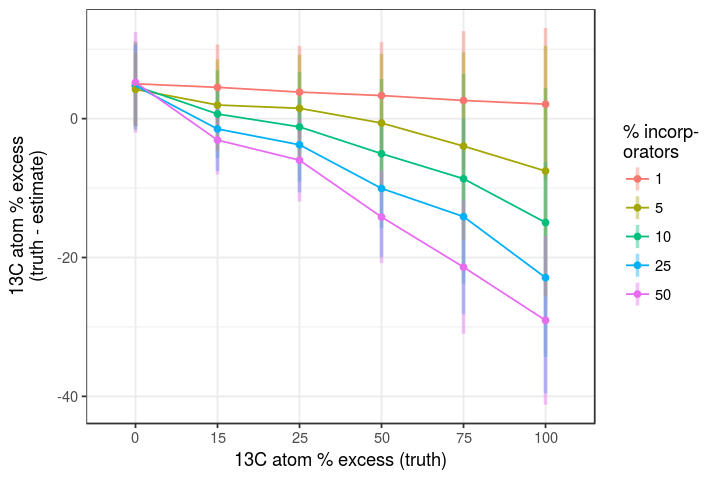

In [62]:
# difference between true and estimated

## q-SIP incorporators 
df.j.dis.qSIP = df.j %>%
    filter(atom_CI_low > 0) %>%     # just incorporators identified by q-SIP
    mutate(delta_excess = atom_fraction_excess * 100 - true_atom_fraction_excess * 100) %>%
    group_by(percIncorp, percTaxa) %>%
    summarize(mean_delta_excess = mean(delta_excess),
              sd_delta_excess = sd(delta_excess)) %>%
    ungroup() %>%
    mutate(percIncorp = percIncorp %>% reorder(percIncorp %>% as.numeric),
           percTaxa = percTaxa %>% reorder(percTaxa %>% as.numeric))
   
# plotting
options(repr.plot.width=6, repr.plot.height=4)
p_qSIP = ggplot(df.j.dis.qSIP, aes(percIncorp, mean_delta_excess, 
                      color=percTaxa, group=percTaxa,
                      ymin=mean_delta_excess-sd_delta_excess,
                     ymax=mean_delta_excess+sd_delta_excess)) +
    geom_linerange(alpha=0.4, size=1) +    
    geom_point() +
    geom_line() +
    #facet_grid(true_incorporator ~ .) +
    scale_color_discrete('% incorp-\norators') +
    labs(x='13C atom % excess (truth)', 
         y='13C atom % excess\n(truth - estimate)') +
    theme_bw() 

p_qSIP

Warning message:
“Removed 1 rows containing missing values (geom_linerange).”

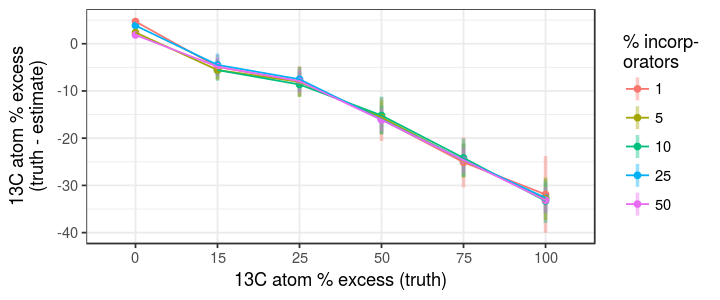

In [63]:
# difference between true and estimated

## q-SIP incorporators 
df.j.dis.qSIP = df.j %>%
    filter(atom_CI_low > 0) %>%     # just incorporators identified by q-SIP
    filter(HWHRSIP_incorp == TRUE) %>%    # just MW-HR-SIP incorporators 
    mutate(delta_excess = atom_fraction_excess * 100 - true_atom_fraction_excess * 100) %>%
    group_by(percIncorp, percTaxa) %>%
    summarize(mean_delta_excess = mean(delta_excess),
              sd_delta_excess = sd(delta_excess)) %>%
    ungroup() %>%
    mutate(percIncorp = percIncorp %>% reorder(percIncorp %>% as.numeric),
           percTaxa = percTaxa %>% reorder(percTaxa %>% as.numeric))
   
# plotting
options(repr.plot.width=6, repr.plot.height=2.5)
p_qSIP = ggplot(df.j.dis.qSIP, aes(percIncorp, mean_delta_excess, 
                      color=percTaxa, group=percTaxa,
                      ymin=mean_delta_excess-sd_delta_excess,
                     ymax=mean_delta_excess+sd_delta_excess)) +
    geom_linerange(alpha=0.4, size=1) +    
    geom_point() +
    geom_line() +
    #facet_grid(true_incorporator ~ .) +
    scale_color_discrete('% incorp-\norators') +
    labs(x='13C atom % excess (truth)', 
         y='13C atom % excess\n(truth - estimate)') +
    theme_bw() 

p_qSIP

Warning message:
“Removed 1 rows containing missing values (geom_linerange).”

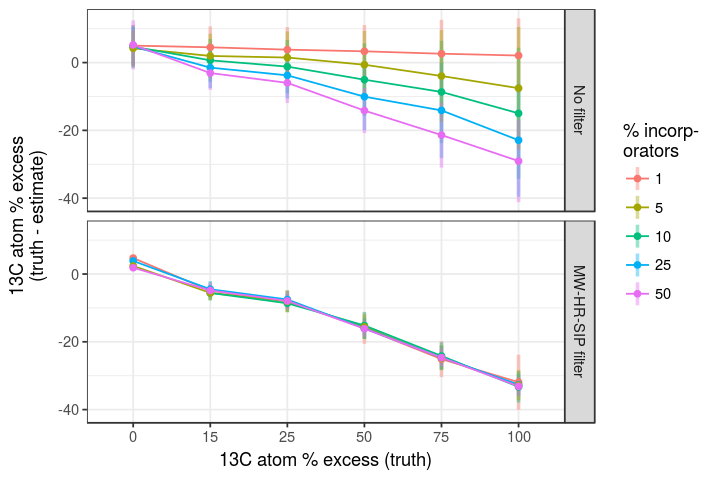

In [64]:
# difference between true and estimated
## q-SIP incorporators 
tmp1 = df.j %>%
    filter(atom_CI_low > 0) %>%     # just incorporators identified by q-SIP
    mutate(delta_excess = atom_fraction_excess * 100 - true_atom_fraction_excess * 100) %>%
    group_by(percIncorp, percTaxa) %>%
    summarize(mean_delta_excess = mean(delta_excess),
              sd_delta_excess = sd(delta_excess)) %>%
    ungroup() %>%
    mutate(percIncorp = percIncorp %>% reorder(percIncorp %>% as.numeric),
           percTaxa = percTaxa %>% reorder(percTaxa %>% as.numeric),
           incorp_called = 'No filter')
## MW-HR-SIP incorporators
tmp2 = df.j %>%
    filter(atom_CI_low > 0) %>%     # just incorporators identified by q-SIP
    filter(HWHRSIP_incorp == TRUE) %>%    # just MW-HR-SIP incorporators 
    mutate(delta_excess = atom_fraction_excess * 100 - true_atom_fraction_excess * 100) %>%
    group_by(percIncorp, percTaxa) %>%
    summarize(mean_delta_excess = mean(delta_excess),
              sd_delta_excess = sd(delta_excess)) %>%
    ungroup() %>%
    mutate(percIncorp = percIncorp %>% reorder(percIncorp %>% as.numeric),
           percTaxa = percTaxa %>% reorder(percTaxa %>% as.numeric),
           incorp_called = 'MW-HR-SIP filter')

# combining tables
df.j.dis.qSIP = rbind(tmp1, tmp2) %>%
    mutate(incorp_called = factor(incorp_called, levels=c('No filter', 'MW-HR-SIP filter')))

   
# plotting
options(repr.plot.width=6, repr.plot.height=4)
p_qSIP = ggplot(df.j.dis.qSIP, aes(percIncorp, mean_delta_excess, 
                      color=percTaxa, group=percTaxa,
                      ymin=mean_delta_excess-sd_delta_excess,
                     ymax=mean_delta_excess+sd_delta_excess)) +
    geom_line() +
    geom_linerange(alpha=0.4, size=1) +    
    geom_point() +
    facet_grid(incorp_called ~ .) +
    scale_color_discrete('% incorp-\norators') +
    labs(x='13C atom % excess (truth)', 
         y='13C atom % excess\n(truth - estimate)') +
    theme_bw() 

p_qSIP

## delta-BD

In [65]:
dBD_files = list.files(path=workDir, pattern='*_dBD.txt', full.names=TRUE, recursive=TRUE)
dBD_files %>% length %>% print

[1] 300


In [66]:
df_dBD = list()
for(F in dBD_files){
    tmp = read.delim(F, sep='\t') 
    FF = strsplit(F, '/') %>% unlist
    FFl = length(FF)
    tmp$percIncorp = FF[FFl-3]
    tmp$percTaxa = FF[FFl-2]
    tmp$rep = FF[FFl-1]
    tmp$file = FF[FFl]
    df_dBD[[F]] = tmp
}

df_dBD = do.call(rbind, df_dBD)
rownames(df_dBD) = 1:nrow(df_dBD)
df_dBD %>% head(n=3) %>% print

                                 taxon mean_CM_control mean_CM_treatment
1       Acaryochloris_marina_MBIC11017        1.720172          1.724404
2 Acetobacter_pasteurianus_IFO_3283-03        1.714859          1.719583
3       Acetobacterium_woodii_DSM_1030        1.710761          1.708133
  stdev_CM_control stdev_CM_treatment     delta_BD percIncorp percTaxa rep
1      0.033328784        0.017888561  0.004231134          0        1   1
2      0.004887423        0.006516244  0.004723806          0        1   1
3      0.006880538        0.002494913 -0.002627739          0        1   1
                        file
1 OTU_abs1e9_PCR_sub_dBD.txt
2 OTU_abs1e9_PCR_sub_dBD.txt
3 OTU_abs1e9_PCR_sub_dBD.txt


### Joining estimate with truth

In [67]:
df.j = inner_join(df_dBD, df_shift, c('taxon' = 'taxon',
                                       'percIncorp'='percIncorp',
                                       'percTaxa'='percTaxa',
                                       'rep'='rep')) %>%
    filter(!is.na(delta_BD)) %>%
    mutate(true_incorporator = ifelse(median_true_BD_shift > 0.002, TRUE, FALSE),
           true_atom_fraction_excess = median_true_BD_shift / 0.036,
           atom_fraction_excess = delta_BD / 0.036)
df.j %>% head(n=3)

Warning message in inner_join_impl(x, y, by$x, by$y, suffix$x, suffix$y):
“joining factors with different levels, coercing to character vector”

,taxon,mean_CM_control,mean_CM_treatment,stdev_CM_control,stdev_CM_treatment,delta_BD,percIncorp,percTaxa,rep,file,median_true_BD_shift,true_incorporator,true_atom_fraction_excess,atom_fraction_excess
1,Acaryochloris_marina_MBIC11017,1.72017237501,1.72440350877,0.0333287835795,0.0178885610258,0.00423113375962,0,1,1,OTU_abs1e9_PCR_sub_dBD.txt,0,FALSE,0,0.117531493322778
2,Acetobacter_pasteurianus_IFO_3283-03,1.71485933284,1.7195831393,0.00488742265951,0.00651624383562,0.00472380645756,0,1,1,OTU_abs1e9_PCR_sub_dBD.txt,0,FALSE,0,0.131216846043333
3,Acetobacterium_woodii_DSM_1030,1.71076084855,1.7081331098,0.00688053751389,0.00249491325664,-0.00262773875329,0,1,1,OTU_abs1e9_PCR_sub_dBD.txt,0,FALSE,0,-0.0729927431469444


### Joining with MW-HR-SIP

In [68]:
df.j = left_join(df.j, df_incorp, c('taxon' = 'taxon',
                                    'percIncorp'='percIncorp',
                                    'percTaxa'='percTaxa',
                                    'rep'='rep')) %>%
    mutate(HWHRSIP_incorp = ifelse(is.na(HWHRSIP_incorp), FALSE, TRUE))

df.j %>% nrow %>% print
df.j %>% head(n=3)

Warning message in left_join_impl(x, y, by$x, by$y, suffix$x, suffix$y):
“joining factor and character vector, coercing into character vector”

[1] 330600


,taxon,mean_CM_control,mean_CM_treatment,stdev_CM_control,stdev_CM_treatment,delta_BD,percIncorp,percTaxa,rep,file,median_true_BD_shift,true_incorporator,true_atom_fraction_excess,atom_fraction_excess,HWHRSIP_incorp
1,Acaryochloris_marina_MBIC11017,1.72017237501,1.72440350877,0.0333287835795,0.0178885610258,0.00423113375962,0,1,1,OTU_abs1e9_PCR_sub_dBD.txt,0,FALSE,0,0.117531493322778,FALSE
2,Acetobacter_pasteurianus_IFO_3283-03,1.71485933284,1.7195831393,0.00488742265951,0.00651624383562,0.00472380645756,0,1,1,OTU_abs1e9_PCR_sub_dBD.txt,0,FALSE,0,0.131216846043333,FALSE
3,Acetobacterium_woodii_DSM_1030,1.71076084855,1.7081331098,0.00688053751389,0.00249491325664,-0.00262773875329,0,1,1,OTU_abs1e9_PCR_sub_dBD.txt,0,FALSE,0,-0.0729927431469444,FALSE


### Plotting results

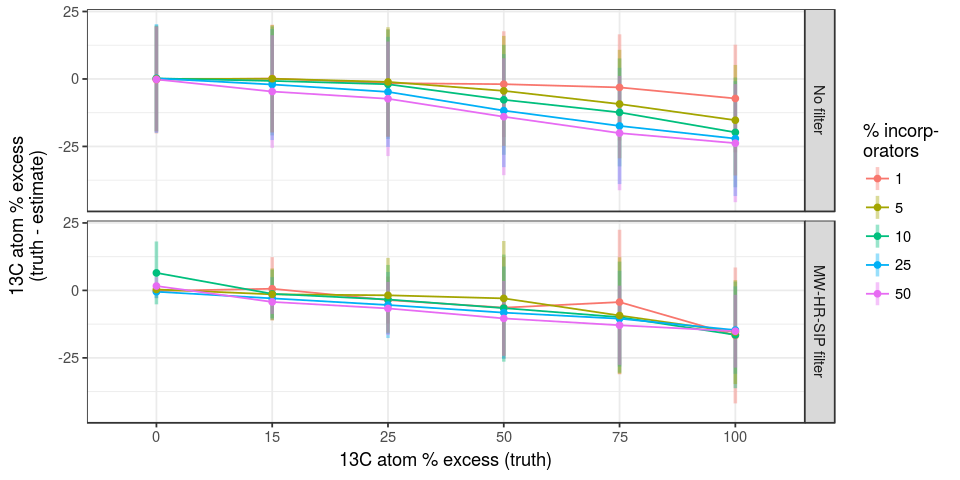

In [69]:
# difference between true and estimated
tmp1 = df.j %>%
    mutate(delta_excess = atom_fraction_excess * 100 - true_atom_fraction_excess * 100) %>%
    group_by(percIncorp, percTaxa) %>%
    summarize(mean_delta_excess = mean(delta_excess),
              sd_delta_excess = sd(delta_excess)) %>%
    ungroup() %>%
    mutate(percIncorp = percIncorp %>% reorder(percIncorp %>% as.numeric),
           percTaxa = percTaxa %>% reorder(percTaxa %>% as.numeric),
           incorp_called = 'No filter')

tmp2 = df.j %>%
    filter(HWHRSIP_incorp == TRUE) %>%    # just MW-HR-SIP incorporators 
    mutate(delta_excess = atom_fraction_excess * 100 - true_atom_fraction_excess * 100) %>%
    group_by(percIncorp, percTaxa) %>%
    summarize(mean_delta_excess = mean(delta_excess),
              sd_delta_excess = sd(delta_excess)) %>%
    ungroup() %>%
    mutate(percIncorp = percIncorp %>% reorder(percIncorp %>% as.numeric),
           percTaxa = percTaxa %>% reorder(percTaxa %>% as.numeric),
           incorp_called = 'MW-HR-SIP filter')

   
# combining tables
df.j.dis.dBD = rbind(tmp1, tmp2) %>%
    mutate(incorp_called = factor(incorp_called, levels=c('No filter', 'MW-HR-SIP filter')))


# plotting
options(repr.plot.width=8, repr.plot.height=4)
p_dBD = ggplot(df.j.dis.dBD, aes(percIncorp, mean_delta_excess, 
                      color=percTaxa, group=percTaxa,
                      ymin=mean_delta_excess-sd_delta_excess,
                     ymax=mean_delta_excess+sd_delta_excess)) +
    geom_line() +
    geom_linerange(alpha=0.4, size=1) +    
    geom_point() +
    facet_grid(incorp_called ~ .) +
    scale_color_discrete('% incorp-\norators') +
    labs(x='13C atom % excess (truth)', 
         y='13C atom % excess\n(truth - estimate)') +
    theme_bw() 

p_dBD 

## Combined plot

Warning message:
“Removed 1 rows containing missing values (geom_linerange).”

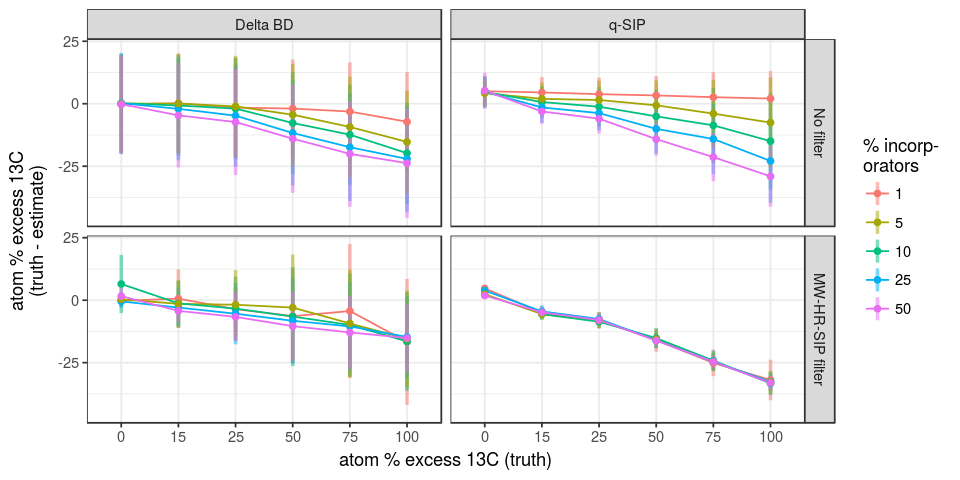

In [70]:
df.jj = rbind(df.j.dis.qSIP %>% mutate(method='qSIP'),
              df.j.dis.dBD %>% mutate(method='Delta BD')) %>%
    mutate(method = gsub('qSIP', 'q-SIP', method))


p.comb = ggplot(df.jj, aes(percIncorp, mean_delta_excess, 
                      color=percTaxa, group=percTaxa,
                      ymin=mean_delta_excess-sd_delta_excess,
                     ymax=mean_delta_excess+sd_delta_excess)) +
    geom_line() +
    geom_linerange(alpha=0.5, size=1) +
    geom_point() +
    scale_color_discrete('% incorp-\norators') +
    labs(x='atom % excess 13C (truth)', 
         y='atom % excess 13C\n(truth - estimate)') +
    facet_grid(incorp_called ~ method) +
    theme_bw() 
p.comb

In [71]:
outF = file.path(workDir, 'atomIncorp_taxaIncorp_BDshift.pdf')
ggsave(outF, p.comb, width=8, height=4)
cat('File written:', outF, '\n')

Warning message:
“Removed 1 rows containing missing values (geom_linerange).”

File written: /ebio/abt3_projects/methanogen_host_evo/SIPSim_pt2/data/bac_genome1147/atomIncorp_taxaIncorp//atomIncorp_taxaIncorp_BDshift.pdf 


In [72]:
outF = file.path(workDir, 'atomIncorp_taxaIncorp_BDshift.jpeg')
ggsave(outF, p.comb, width=8, height=4)
cat('File written:', outF, '\n')

Warning message:
“Removed 1 rows containing missing values (geom_linerange).”

File written: /ebio/abt3_projects/methanogen_host_evo/SIPSim_pt2/data/bac_genome1147/atomIncorp_taxaIncorp//atomIncorp_taxaIncorp_BDshift.jpeg 


# Why does q-SIP under-estimate true incorp?

* for true incorporators, q-SIP seems to show ~30% under-estimation in atom % excess 13C
  * is this due to low abundance taxa 'heavy' tail having high levels of noise?

## True BD shift

In [73]:
BDshift_files = list.files(path=workDir, pattern='BD-shift_stats.txt', full.names=TRUE, recursive=TRUE)
BDshift_files %>% length %>% print

[1] 300


In [74]:
df_shift = list()
for(F in BDshift_files){
    tmp = read.delim(F, sep='\t') 
    FF = strsplit(F, '/') %>% unlist
    FFl = length(FF)
    tmp$percIncorp = FF[FFl-3]
    tmp$percTaxa = FF[FFl-2]
    tmp$rep = FF[FFl-1]
    tmp$file = FF[FFl]
    df_shift[[F]] = tmp
}

df_shift = do.call(rbind, df_shift)
rownames(df_shift) = 1:nrow(df_shift)

df_shift = df_shift %>%
    filter(library %in% c(2,4,6)) %>%
    group_by(taxon, percIncorp, percTaxa, rep) %>%
    summarize(median = median(median)) %>%
    ungroup() %>%
    rename('median_true_BD_shift' = median) 

# status
df_shift %>% nrow %>% print
df_shift %>% head(n=3)

[1] 330600


,taxon,percIncorp,percTaxa,rep,median_true_BD_shift
1,Acaryochloris_marina_MBIC11017,0,1,1,0
2,Acaryochloris_marina_MBIC11017,0,1,10,0
3,Acaryochloris_marina_MBIC11017,0,1,2,0


## q-SIP

In [75]:
atomX_files = list.files(path=workDir, pattern='*_qSIP_atom.txt', full.names=TRUE, recursive=TRUE)
atomX_files %>% length %>% print

[1] 300


In [76]:
df_atomX = list()
for(F in atomX_files){
    tmp = read.delim(F, sep='\t') 
    FF = strsplit(F, '/') %>% unlist
    FFl = length(FF)
    tmp$percIncorp = FF[FFl-3]
    tmp$percTaxa = FF[FFl-2]
    tmp$rep = FF[FFl-1]
    tmp$file = FF[FFl]
    df_atomX[[F]] = tmp
}

df_atomX = do.call(rbind, df_atomX)
rownames(df_atomX) = 1:nrow(df_atomX)
df_atomX %>% head(n=3) %>% print

                                 taxon  control treatment       BD_diff
1       Acaryochloris_marina_MBIC11017 1.711015        NA            NA
2 Acetobacter_pasteurianus_IFO_3283-03 1.712271  1.711311 -0.0009600536
3       Acetobacterium_woodii_DSM_1030 1.705148  1.703813 -0.0013348264
  control_GC control_MW treatment_max_MW treatment_MW atom_fraction_excess
1  0.7778801   308.0768         317.6634           NA                   NA
2  0.7929281   308.0843         317.6634     307.9116          -0.01783259
3  0.7076277   308.0420         317.6636     307.8008          -0.02478392
  atom_CI_low atom_CI_high percIncorp percTaxa rep
1          NA           NA          0        1   1
2 -0.05099068   0.01526571          0        1   1
3 -0.08805054   0.03707605          0        1   1
                              file
1 OTU_abs1e9_PCR_sub_qSIP_atom.txt
2 OTU_abs1e9_PCR_sub_qSIP_atom.txt
3 OTU_abs1e9_PCR_sub_qSIP_atom.txt


## Original taxon abundances

In [77]:
comm_files = list.files(path=workDir, pattern='comm.txt', full.names=TRUE, recursive=TRUE)
comm_files %>% length %>% print

[1] 300


In [78]:
df_comm = list()
for(F in comm_files){
    tmp = read.delim(F, sep='\t') 
    FF = strsplit(F, '/') %>% unlist
    FFl = length(FF)
    tmp$percIncorp = FF[FFl-3]
    tmp$percTaxa = FF[FFl-2]
    tmp$rep = FF[FFl-1]
    tmp$file = FF[FFl]
    df_comm[[F]] = tmp
}

df_comm = do.call(rbind, df_comm)
rownames(df_comm) = 1:nrow(df_comm)


# mean abund for libraries
df_comm = df_comm %>%
    rename('taxon' = taxon_name) %>%
    mutate(rel_abund_perc = ifelse(is.na(rel_abund_perc), 0, rel_abund_perc)) %>%
    group_by(taxon, percIncorp, percTaxa, rep) %>%
    summarize(any_zero = any(rel_abund_perc == 0),
              mean_rel_abund_perc = mean(rel_abund_perc),
              mean_rank_abund = mean(rank)) %>%
    ungroup()

# status
df_comm %>% nrow %>% print
df_comm %>% head(n=3)

[1] 344100


,taxon,percIncorp,percTaxa,rep,any_zero,mean_rel_abund_perc,mean_rank_abund
1,Acaryochloris_marina_MBIC11017,0,1,1,FALSE,0.000160130833333333,1132
2,Acaryochloris_marina_MBIC11017,0,1,10,FALSE,0.00469008133333333,798
3,Acaryochloris_marina_MBIC11017,0,1,2,FALSE,0.00977526783333333,647


In [79]:
df_comm$any_zero %>% table

.
 FALSE 
344100 

### Joining estimate with true values

In [80]:
# table join
join_vars = c('taxon' = 'taxon',
              'percIncorp'='percIncorp',
              'percTaxa'='percTaxa',
              'rep'='rep')

df_atomX %>% nrow %>% print

# joining q-SIP + true-BD
df.j = left_join(df_atomX, df_shift, join_vars) %>%
    filter(atom_CI_low > 0) %>%
    filter(!is.na(BD_diff)) %>%
    mutate(true_incorporator = ifelse(median_true_BD_shift > 0.002, TRUE, FALSE),
          true_atom_fraction_excess = median_true_BD_shift / 0.036,
          atom_fraction_excess = ifelse(is.na(atom_CI_low), 0, atom_fraction_excess)) %>%
    #filter(true_incorporator == TRUE) %>%
    mutate(delta_excess = atom_fraction_excess * 100 - true_atom_fraction_excess * 100)
df.j %>% nrow %>% print

# joining with abundances
df.j = df.j %>%
    inner_join(df_comm, join_vars) %>%
    mutate(percIncorp = percIncorp %>% as.character,
           percTaxa = percTaxa %>% as.character,
           percIncorp = percIncorp %>% reorder(percIncorp %>% as.numeric),
           percTaxa = percTaxa %>% reorder(percTaxa %>% as.numeric))

# status
df.j %>% nrow %>% print
df.j %>% head(n=3) %>% print

[1] 344100


Warning message in left_join_impl(x, y, by$x, by$y, suffix$x, suffix$y):
“joining factors with different levels, coercing to character vector”

[1] 79382


Warning message in inner_join_impl(x, y, by$x, by$y, suffix$x, suffix$y):
“joining character vector and factor, coercing into character vector”

[1] 79382
                        taxon  control treatment     BD_diff control_GC
1    Acholeplasma_palmae_J233 1.695594  1.698140 0.002545139  0.5932193
2 Acinetobacter_pittii_PHEA-2 1.697151  1.715720 0.018569120  0.6118631
3   Aeromonas_hydrophila_4AK4 1.716773  1.727863 0.011089723  0.8468379
  control_MW treatment_max_MW treatment_MW atom_fraction_excess atom_CI_low
1   307.9852         317.6639     308.4475           0.04723338  0.02876427
2   307.9945         317.6639     311.3644           0.34463603  0.04828482
3   308.1110         317.6633     310.1013           0.20604288  0.02237359
  atom_CI_high percIncorp percTaxa rep                             file
1   0.06612216          0        1   1 OTU_abs1e9_PCR_sub_qSIP_atom.txt
2   0.66004825          0        1   1 OTU_abs1e9_PCR_sub_qSIP_atom.txt
3   0.37948852          0        1   1 OTU_abs1e9_PCR_sub_qSIP_atom.txt
  median_true_BD_shift true_incorporator true_atom_fraction_excess delta_excess
1                    0        

## Plotting BD `taxa_abund ~ BD_shift_accuracy`

`geom_smooth()` using method = 'gam'


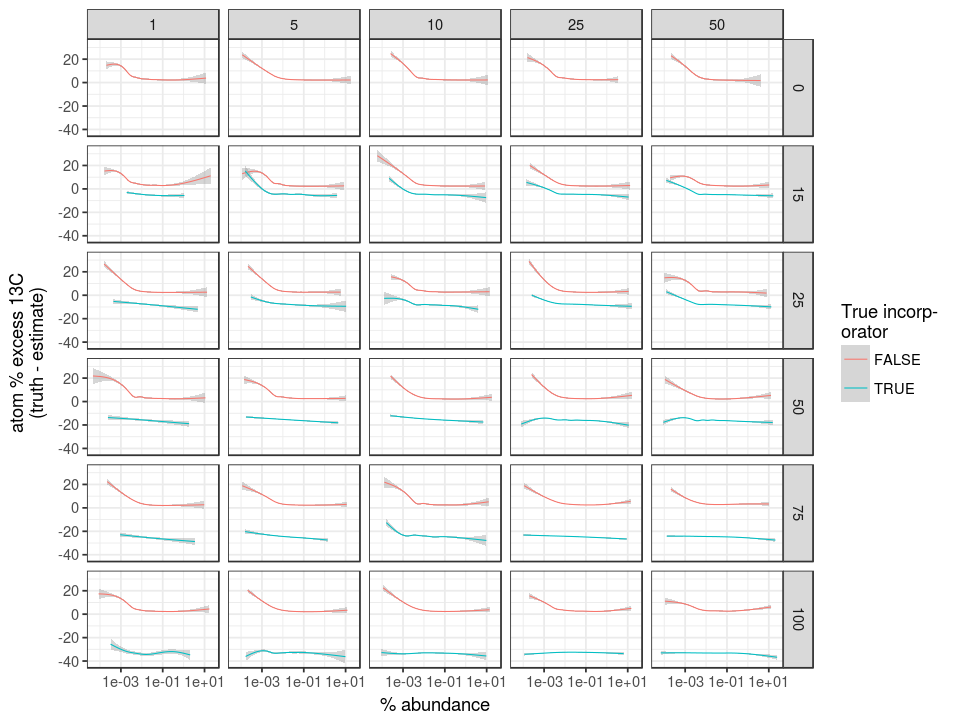

In [81]:
options(repr.plot.width=8, repr.plot.height=6)
p.qSIP_abund = ggplot(df.j, aes(mean_rel_abund_perc, delta_excess, 
                                color=true_incorporator, group=true_incorporator)) +
    #geom_point(shape='O', alpha=0.15, size=0.5) +
    geom_smooth(size=0.3) +
    scale_x_log10() +
    scale_color_discrete('True incorp-\norator') +
    labs(x='% abundance', 
         y='atom % excess 13C\n(truth - estimate)') +
    facet_grid(percIncorp ~ percTaxa) +
    theme_bw() 

p.qSIP_abund

In [82]:
outF = file.path(workDir, 'atomIncorp_taxaIncorp_qSIP-abund.pdf')
ggsave(outF, p.qSIP_abund, width=9, height=6)
cat('File written:', outF, '\n')

`geom_smooth()` using method = 'gam'


File written: /ebio/abt3_projects/methanogen_host_evo/SIPSim_pt2/data/bac_genome1147/atomIncorp_taxaIncorp//atomIncorp_taxaIncorp_qSIP-abund.pdf 


In [83]:
outF = file.path(workDir, 'atomIncorp_taxaIncorp_qSIP-abund.jpeg')
ggsave(outF, p.qSIP_abund, width=9, height=6)
cat('File written:', outF, '\n')

`geom_smooth()` using method = 'gam'


File written: /ebio/abt3_projects/methanogen_host_evo/SIPSim_pt2/data/bac_genome1147/atomIncorp_taxaIncorp//atomIncorp_taxaIncorp_qSIP-abund.jpeg 
